In [1]:
import dicom
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [2]:
dicom_files = [x for x in Path('../Data/torso/rfmri/MR').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)

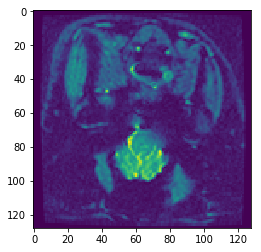

In [3]:
# here's our sample pig in false color image form (viridis cmap)
pig0 = dicom.read_file(str(dicom_files[22]), force=True)
im = pig0.pixel_array
plt.imshow(im, cmap='viridis')

In [4]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, depth, height, width]

im = pig0.pixel_array
all_data = np.zeros((120, 47, im.shape[0], im.shape[1]))

for f in tqdm_notebook(dicom_files):
    pigfile = dicom.read_file(str(f), force=True)
    
    try:
    
        time = (pigfile.InstanceNumber - 1) // 47
        depth = pigfile.InStackPositionNumber - 1


        if np.count_nonzero(all_data[time, depth]) > 0:
            print('repeated stack position @ time %d , depth %d' % (time, depth))

        all_data[time, depth, ...] = pigfile.pixel_array
    except:
        print(f)
    

In [5]:
assert all_data.shape == (120, 47, 128, 128) # basic sanity check

In [6]:
# extract all slices at t=0 in png to annotate with imagej
slicedir = Path('../Data/torso/seg_slices')
slicedir.mkdir(exist_ok=True)

for i, brain_slice in enumerate(tqdm_notebook(all_data[0])):
    filename = '../Data/torso/seg_slices/slice_{}.png'.format(i)
    scipy.misc.toimage(brain_slice).save(filename)
    
    
# then use this thing to segment in 3d http://imagej.net/Trainable_Weka_Segmentation

In [9]:
# gotta transform the segmentation mask into a binary image
color_mask = io.imread('../Data/torso/t0_segment_v1.tif')
binary_mask = np.zeros(color_mask.shape[:-1])


for i, z_slice in enumerate(color_mask):
    gray_slice = skimage.color.rgb2gray(z_slice)
    
    if np.max(gray_slice) == np.min(gray_slice):
        # only one color in this slice, it must be background
        print('no foreground in slice %d' % i)
        binary_slice = np.zeros(gray_slice.shape[:2])
        
    else:
        thresh = threshold_otsu(gray_slice)
        binary_slice = gray_slice <= thresh

    
    binary_mask[i] = binary_slice

io.imsave('../Data/torso/t0_bin_segment_v1.tif', binary_mask)

no foreground in slice 0
no foreground in slice 1
no foreground in slice 2
no foreground in slice 3
no foreground in slice 4
no foreground in slice 5
no foreground in slice 45


In [10]:
# use annotation to select pixels from volume
binary_mask = io.imread('../Data/torso/t0_bin_segment_v1.tif')

indices = np.nonzero(binary_mask)


df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['depth', 'row', 'col'])
series_df = pd.Series(index=df_index, dtype=object)


for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    d, r, c = triple
    trace = all_data[:, d, r, c]
    
    series_df.loc[triple] = trace

In [11]:
def model():
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
    
    # padding is unspecified in paper, but maybe should be causal
    # encoder
    model.add(Conv1D(32, 6, padding='causal', input_shape=[120, 1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(64, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(128, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(256, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    

    # decoder
    model.add(Conv1D(256, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(128, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(64, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(32, 6, padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    return model


m = model()

from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
# def step_decay(epoch):
# 	initial_lrate = 0.1
# 	lrate = initial_lrate * (.8 ** (epoch/10))
# 	return lrate

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]


# no optimizer specified, but let's use rmsprop
from keras import optimizers

opt = optimizers.RMSprop(lr=0.01)
m.compile(optimizer=opt, loss='mse')
    

In [12]:
data_block = np.vstack(series_df.values)[..., np.newaxis]

# extract train / val sets

shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)

validation_set = shuffled_data[:1000]  #hold back 1000 for validation
training_set = shuffled_data[1000:]   #train on 12550 samples

In [13]:
print(validation_set.shape)
print(data_block.shape)

(1000, 120, 1)
(13550, 120, 1)


In [14]:
print('are you sure you want to start training')
are_you_sure = input()

if are_you_sure.lower() != 'yes':
    raise Exception()

m.fit(training_set, training_set, epochs=50, batch_size=32, callbacks=callbacks_list)

are you sure you want to start training
yes
Epoch 1/50
12550/12550 [==============================] - 113s - loss: 2648196.8946   
Epoch 2/50
12550/12550 [==============================] - 101s - loss: 473291.4453   
Epoch 3/50
12550/12550 [==============================] - 117s - loss: 21611.8472   
Epoch 4/50
12550/12550 [==============================] - 132s - loss: 15024.6678   
Epoch 5/50
12550/12550 [==============================] - 136s - loss: 13363.0780   
Epoch 6/50
12550/12550 [==============================] - 101s - loss: 12037.0827   
Epoch 7/50
12550/12550 [==============================] - 106s - loss: 11393.7352   
Epoch 8/50
12550/12550 [==============================] - 101s - loss: 11660.1433   
Epoch 9/50
12550/12550 [==============================] - 102s - loss: 10806.7233   
Epoch 10/50
12550/12550 [==============================] - 101s - loss: 10337.2837   
Epoch 11/50
12550/12550 [==============================] - 107s - loss: 9971.7384   
Epoch 12/50
12550

In [15]:
m.evaluate(validation_set, validation_set)
m.save('model_e9.h5')

 992/1000 [============================>.] - ETA: 0s

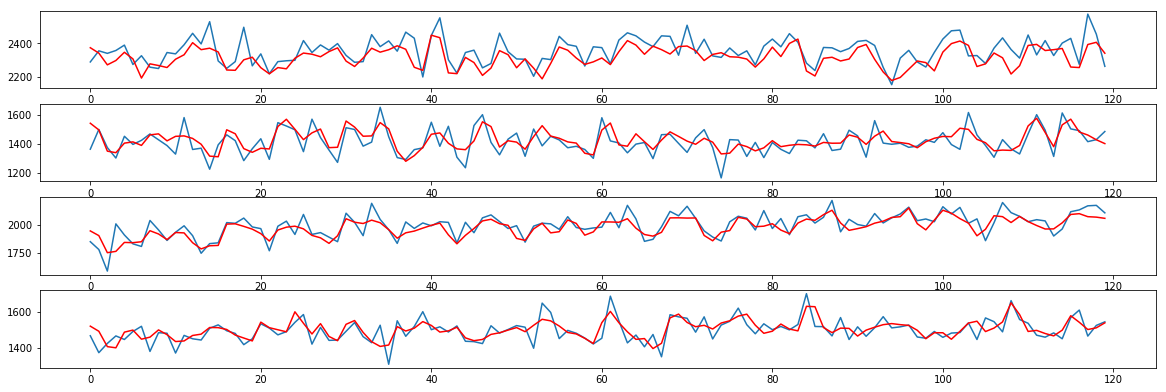

In [17]:
from keras import backend as K
from keras.models import load_model

sample_1 = data_block[np.newaxis, 1000]
output_1 = m.predict(sample_1)

sample_2 = data_block[np.newaxis, 10]
output_2 = m.predict(sample_2)

sample_3 = data_block[np.newaxis, 66]
output_3 = m.predict(sample_3)

sample_4 = data_block[np.newaxis, 10000]
output_4 = m.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')



